# Лабораторная на Классификацию

В ходе этой работы мы проведём классификацию на синтетических данных

## Импортируем библиотеки

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.datasets import make_moons

## Генерируем данные с распределением в виде "Инь-Ян"

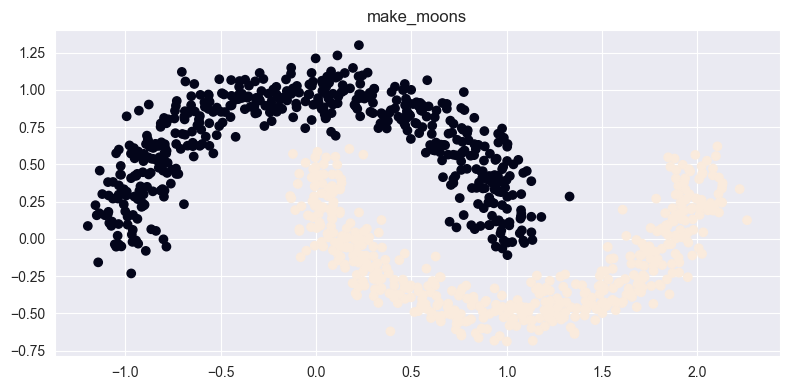

In [34]:
# Сгенерируем 1000 точек в виде Инь-Ян с помощью знакомой нам библиотеки и добавим немного шума
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

X, Y = make_moons(n_samples=1_000, noise=0.1, random_state=41)
ax.scatter(X[:, 0], X[:, 1], c=Y)
ax.set_title("make_moons")

plt.tight_layout()
plt.show()

Как мы видим вышел очень красивый Инь-Ян из данных, теперь попробуем ими воспользоваться для обучения модели (данные синтетические, поэтому обрабатывать их и как либо работать с ними не нужно).

##

##

##

## Вывод
В целом удалось хорошо кластеризовать данные (выделил 3 кластера, где видно горячих, холодных и обычных клиентов банка, k=3), хоть и изначально целевая была всего 2. Кластеры отлично связаны с целевой переменной, а с категориальными данными разнообразно (не плохо, значит уже хорошо). Новые признаки помогли бы кластеризации, но к сожалению я их не сделал, тк нет с чем сравнить. Если говорить в целом, то кластеризация вышла очень успешно! (надеюсь ничего не напортачил и всё хорошо, я старалься)